In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import starry
import warnings
from scipy.special import legendre
from scipy.integrate import quad


warnings.filterwarnings("ignore")
starry.config.lazy = False
starry.config.quiet = True

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [4]:
def phi(y, r=np.inf):
    return np.arcsin(y) + 2 * (1 - np.sqrt(1 - y ** 2)) / (y * r)

def transform(x, y, rs=np.inf):
    # Radial coordinate on disk
    rho = np.sqrt(x ** 2 + y ** 2)
    
    # Angular coordinate on disk (conserved)
    t = np.arctan2(y, x)

    # z coordinate on sphere
    z_ = np.cos(phi(rho, rs))

    # Compute x and y from conserved angle
    x_ = np.sign(x) * np.sqrt((1 - z_ ** 2) / (1 + np.tan(t) ** 2))
    y_ = np.sign(y) * np.sqrt(1 - x_ ** 2 - z_ ** 2)

    # Conver to lat-lon
    lat = np.arcsin(y_)
    lon = np.arctan2(x_, z_)
    return lat * 180 / np.pi, lon * 180 / np.pi

def show(map, nx=300, ax=None, rs=np.inf):
    x, y = np.linspace(-1, 1, nx), np.linspace(-1, 1, nx)
    x, y = np.meshgrid(x, y)
    x = x.flatten()
    y = y.flatten()
    lat, lon = transform(x, y, rs=rs)
    I = map.intensity(lat=lat , lon=lon).reshape(nx, nx)
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(5, 5))
        ax.set_aspect(1)
        ax.axis("off")
    ax.imshow(I, origin="lower")
    

def show_ylms(lmax=5, **kwargs):
    # Set up the plot
    fig, ax = plt.subplots(lmax + 1, 2 * lmax + 1, figsize=(9, 6))
    fig.subplots_adjust(hspace=0)
    for axis in ax.flatten():
        axis.set_xticks([])
        axis.set_yticks([])
        axis.spines["top"].set_visible(False)
        axis.spines["right"].set_visible(False)
        axis.spines["bottom"].set_visible(False)
        axis.spines["left"].set_visible(False)
    for l in range(lmax + 1):
        ax[l, lmax - l].set_ylabel(
            r"$l = %d$" % l,
            rotation="horizontal",
            labelpad=15,
            y=0.35,
            fontsize=11,
            alpha=0.5,
        )
    for j, m in enumerate(range(-lmax, lmax + 1)):
        if m < 0:
            ax[-1, j].set_xlabel(
                r"$m {=} $-$%d$" % -m,
                labelpad=5,
                fontsize=11,
                rotation=45,
                x=0.3,
                alpha=0.5,
            )
        else:
            ax[-1, j].set_xlabel(
                r"$m = %d$" % m,
                labelpad=5,
                fontsize=11,
                rotation=45,
                x=0.35,
                alpha=0.5,
            )

    # Loop over the orders and degrees
    map = starry.Map(lmax)
    for i, l in enumerate(range(lmax + 1)):
        for j, m in enumerate(range(-l, l + 1)):

            # Offset the index for centered plotting
            j += lmax - l

            # Compute the spherical harmonic
            map.reset()
            if l > 0:
                map[l, m] = 1.0
            show(map, ax=ax[i, j], **kwargs)
            ax[i, j].axis("on")
            ax[i, j].set_rasterization_zorder(1)

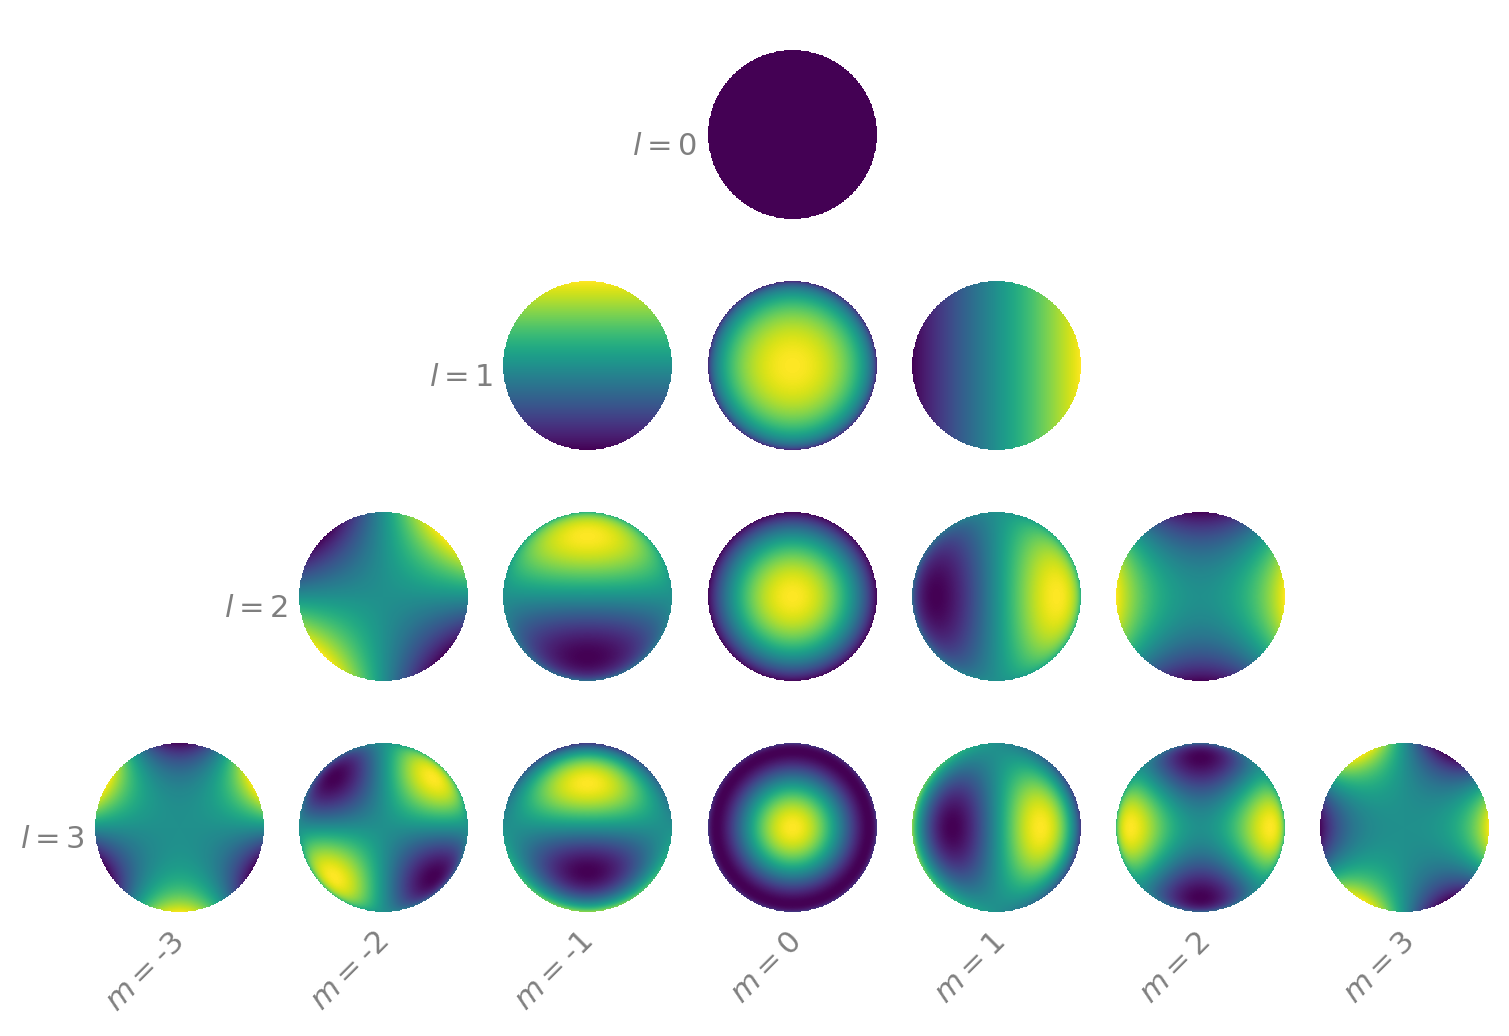

In [5]:
show_ylms(lmax=3, rs=np.inf)

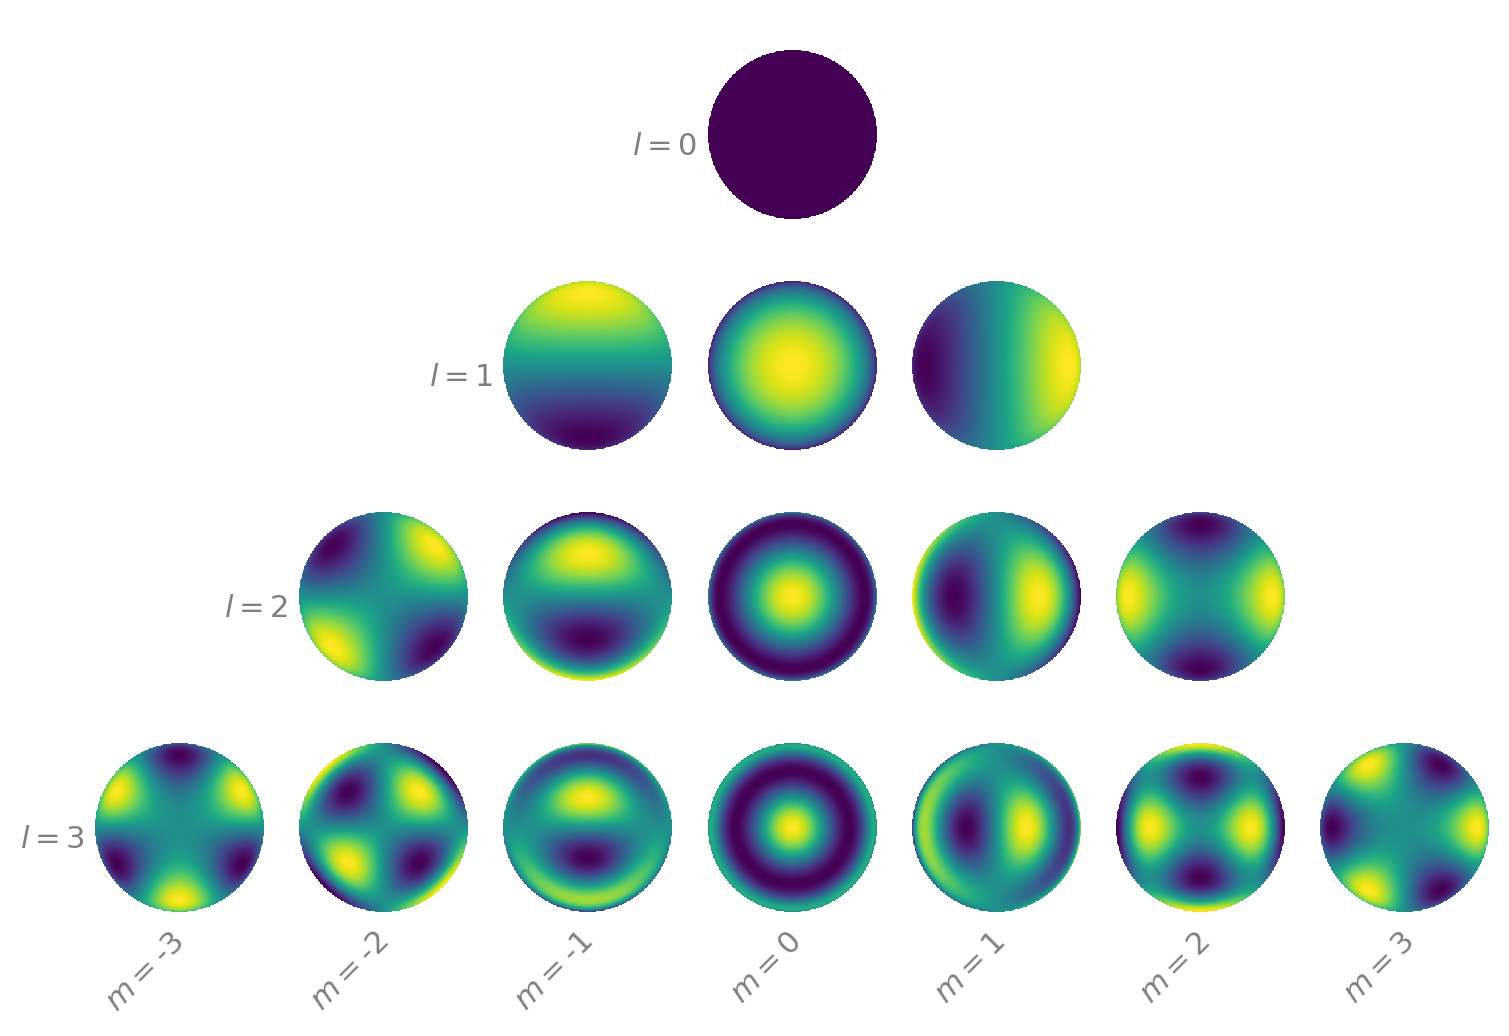

In [6]:
show_ylms(lmax=3, rs=2)

In [11]:
def energy(r, theta, rs, vrot):
    """
    the relation between the energy observed at 
    infinite distance and the emitted energy at the surface
    """
    y = r * np.sin(theta)
    e = 1 - y * vrot * np.sin(theta) + (y**2 - 1/2) * vrot**2 * np.sin(theta)**2 - 1/rs * (1 - (y**2 - 1/2) * vrot**2 * np.sin(theta)**2)
    return e


The energy factor we're interested in here is: 
$$e/e_{surf} = 1 - yv_{rot}\sin{\theta_0} + (y^2 - 1/2)v_{rot}^2\sin{\theta_0^2} - \frac{1}{r_s}(1-(y^2 - 1/2)v_{rot}^2\sin{\theta_0}^2)$$

In [12]:
theta = np.linspace(0, 360, 100)

In [13]:
# import numpy as np
# from scipy import integrate, special

# def colat(r, rs):
#     return 2 * (1 - np.sqrt(1 - r**2)) / (r * rs)

# def spherical_harmonic_intensity(l, rs):
#     def integrand(r):
#         x = np.sqrt(1 - r**2) * np.cos(colat(r, rs)) - r * np.sin(colat(r, rs))
#         return special.legendre(l)(x) * r
    
#     result, _ = integrate.quad(integrand, 0, 1)
#     Fl = 2 * np.sqrt(2 * l + 1) * result #* energy(r, l, theta, rs, vrot)
#     return Fl

# intensity = spherical_harmonic_intensity(30, 30)


The intensity of the spherical harmonic $Y_{l,0}$ projected onto the disk is

$$
F_l = 2\sqrt{2l + 1}\int_0^1 P_l\left( \sqrt{1 - r^2} \cos \theta(r) - r \sin \theta(r) \right) r dr
$$

where

$$
\theta(r) = 2 \frac{1 - \sqrt{1 - r^2}}{r r_s}
$$

$\theta$ is the colatitude.
For a ray with impact parameter $b = xb_{NS}$, the colatitude at which it intersects the surface should be such that $\sin\theta_0 = y/x$, where $y=x\sin\theta_0$.

In [14]:
def spherical_harmonic_intensity(r, l, rs, vrot):
    t = 2 * (1 - np.sqrt(1 - r**2)) / (r * rs)
    coslat = np.sqrt(1 - r**2) * np.cos(t) - r * np.sin(t)
    return np.sqrt(2 * l + 1) / np.pi * legendre(l)(coslat) * energy(r=r, theta=t, rs=rs, vrot=vrot)

In [15]:
spherical_harmonic_intensity(1,30,30,0.3)

0.15492877159813456

In [16]:
r=1
rs=10
t = 2 * (1 - np.sqrt(1 - r**2)) / (r * rs) 
coslat = np.sqrt(1 - r**2) * np.cos(t) - r * np.sin(t)

In [17]:
np.arccos(coslat) * 180 / np.pi

101.45915590261647

In [18]:
# def ylms(lmax, rs):
#     I = np.zeros((lmax + 1) ** 2)
#     for l in range(lmax + 1):
#         n = l ** 2 + l
#         I[n] = 2 * np.pi * spherical_harmonic_intensity(lmax, rs)
#     return I

In [19]:
def ylm_integrals(lmax, rs, vrot=0.3):
    I = np.zeros((lmax + 1) ** 2)
    for l in range(lmax + 1):
        n = l ** 2 + l
        I[n] = 2 * np.pi * quad(lambda r: r * spherical_harmonic_intensity(r, l, rs, vrot), 0, 1)[0]
    return I

In [10]:
ylm_integrals(30, 10)

array([ 8.97276305e-01,  0.00000000e+00,  9.30747090e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  3.17514562e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -7.84552738e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -5.16205468e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  4.28025361e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.06694642e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [14]:
# def design_matrix(lmax, theta, rs, inc=90):
#     map = starry.Map(lmax)
#     rT = ylms(lmax, rs=rs).reshape(1, -1)
#     return map.ops.right_project(
#         rT,
#         np.array(inc * np.pi / 180),
#         np.array(0.0),
#         np.atleast_1d(theta) * np.pi / 180,
#     )

In [20]:
def design_matrix(theta, rs, lmax=30, inc=90, vrot=0.3):
    map = starry.Map(lmax)
    rT = ylm_integrals(lmax, rs, vrot).reshape(1, -1)
    return map.ops.right_project(
        rT,
        np.array(inc * np.pi / 180),
        np.array(0.0),
        np.atleast_1d(theta) * np.pi / 180,
    )

In [21]:
def flux(y, lmax, theta, rs, inc, vrot=0.3):
    A = design_matrix(theta, rs, lmax, inc, vrot)
    return A @ y

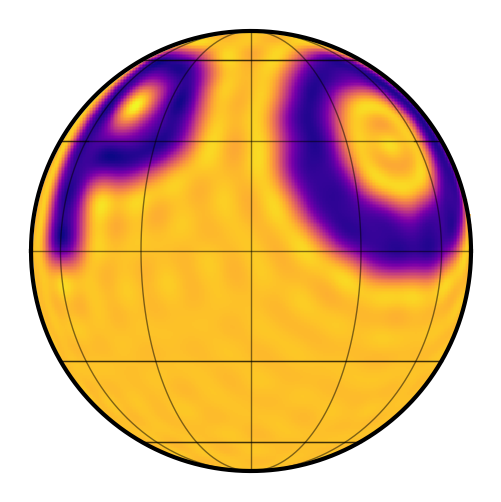

In [22]:
map = starry.Map(30)
map.load("spot")
map.amp = 1
map.show()

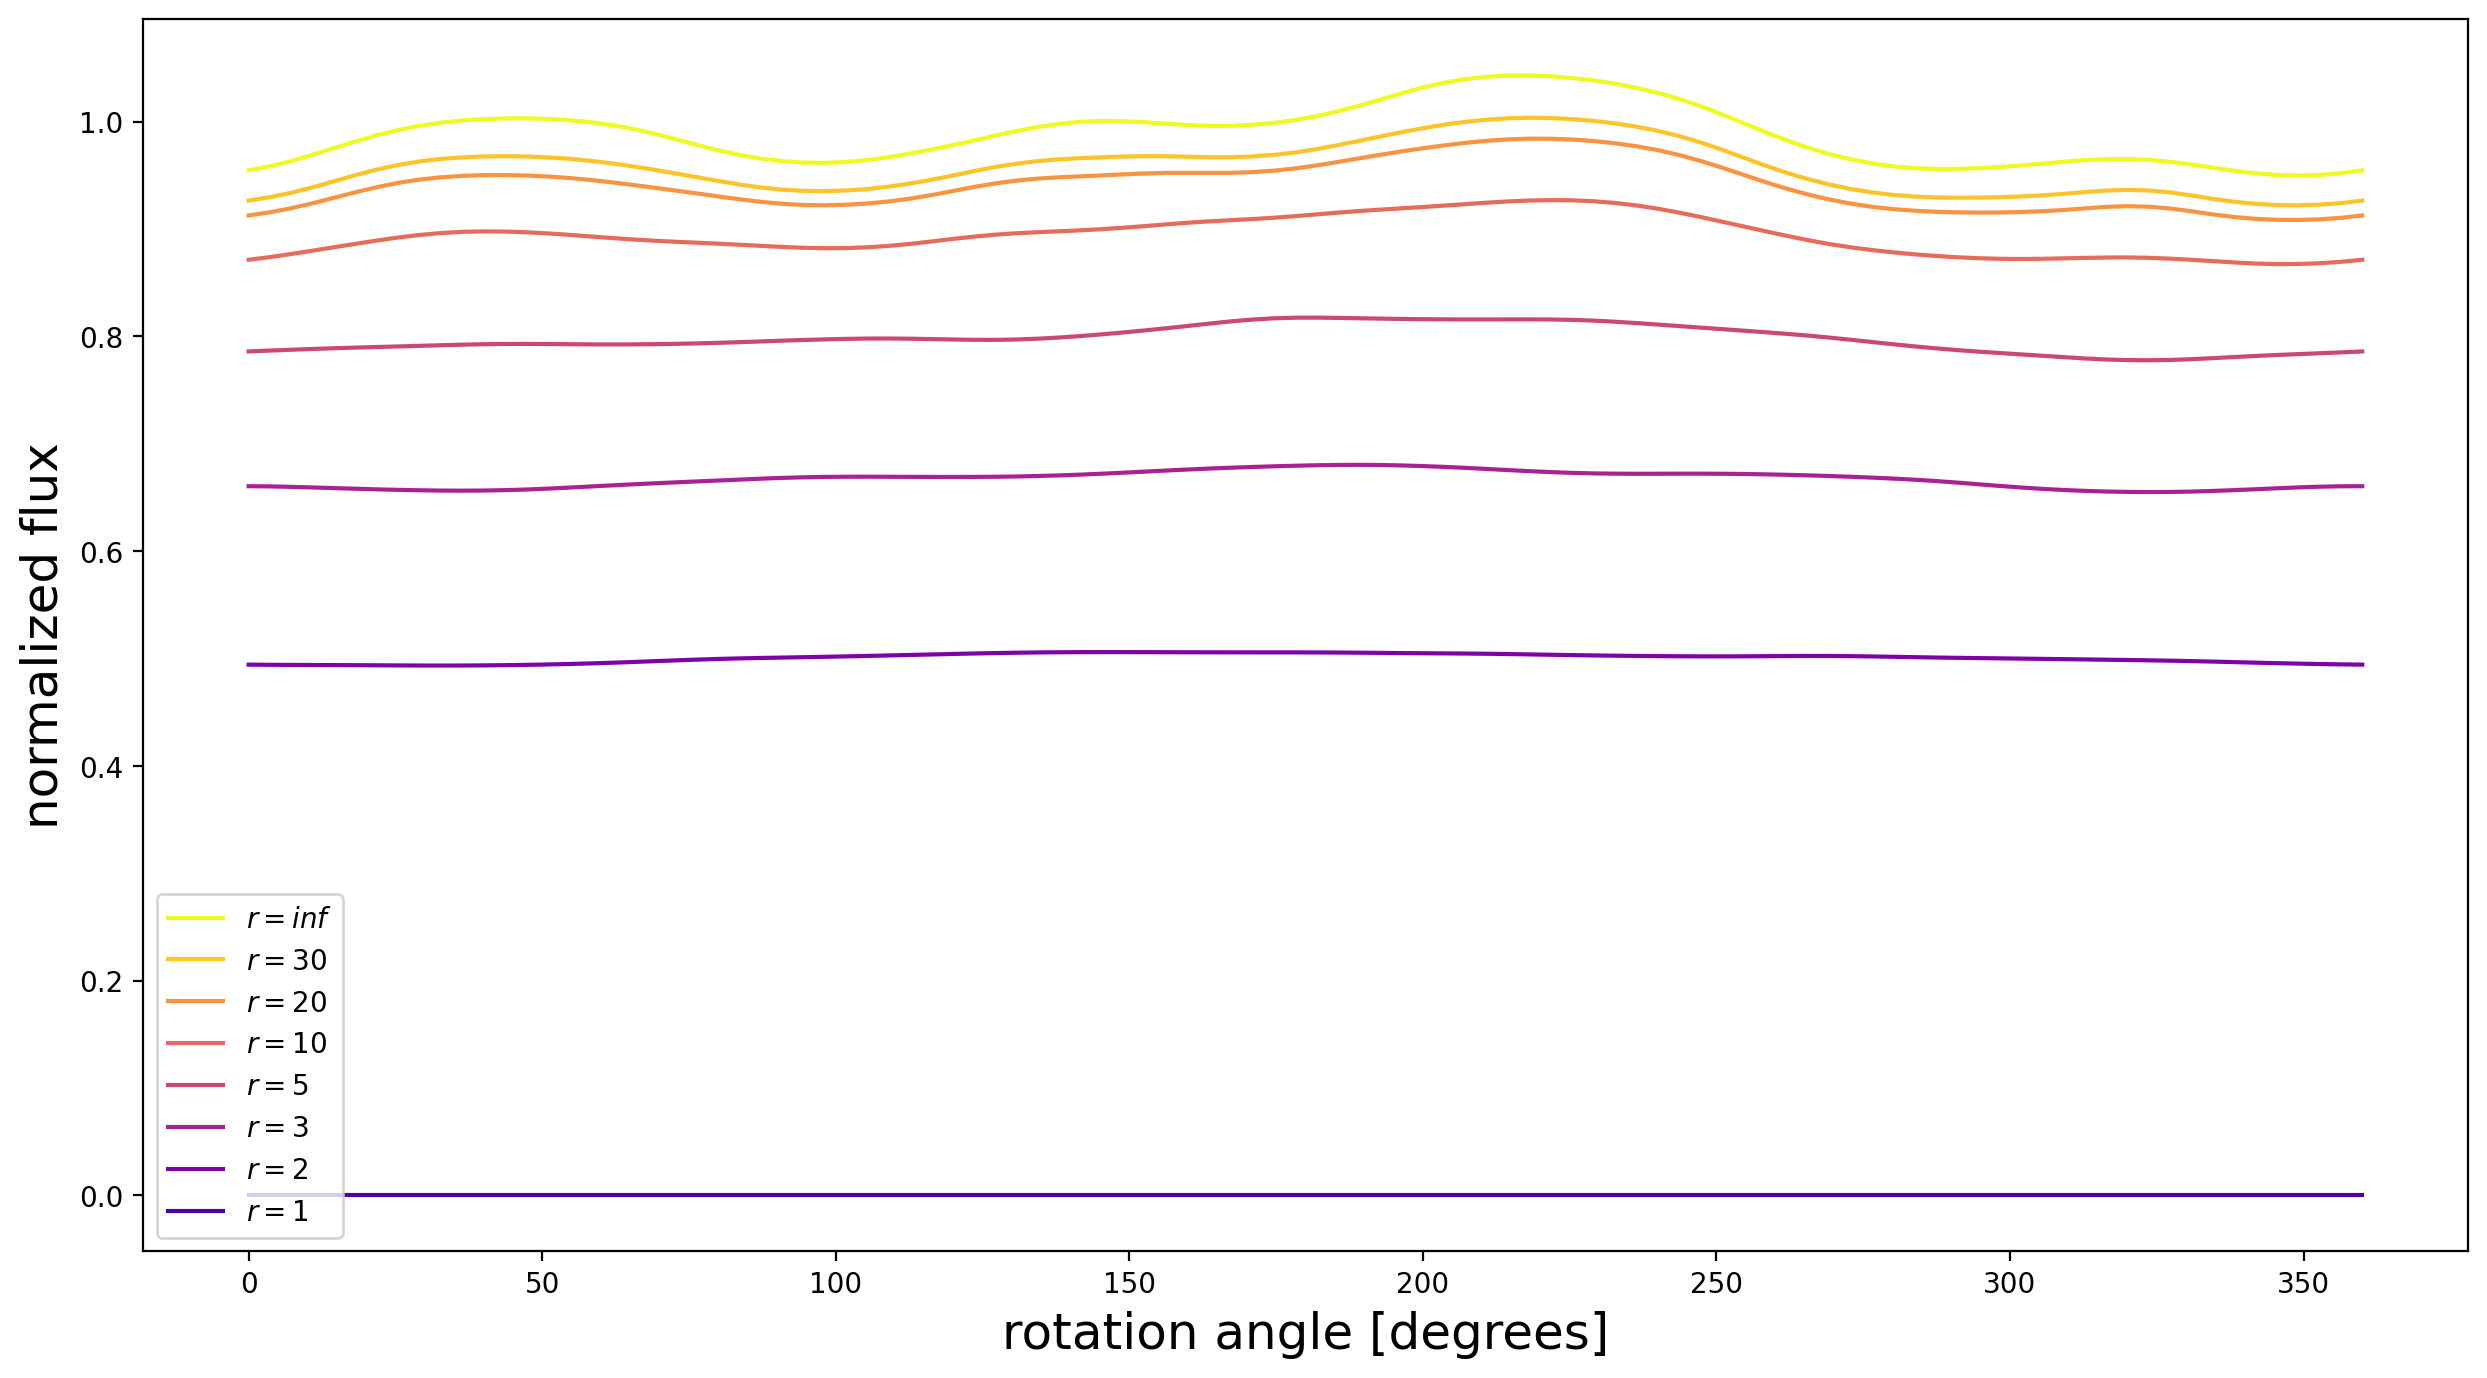

In [24]:
fig, ax = plt.subplots(1, figsize=(15, 8))
cmap = plt.get_cmap("plasma_r")
for n, x in enumerate([np.inf, 30, 20, 10, 5, 3, 2, 1]):
    plt.plot(theta, flux(lmax=30, rs=x, theta=theta, y=map.y, inc=90, vrot=0), label=f"$r={x}$", color=cmap(n/8))
plt.xlabel("rotation angle [degrees]", fontsize=18)
plt.ylabel("normalized flux", fontsize=18)
plt.legend()

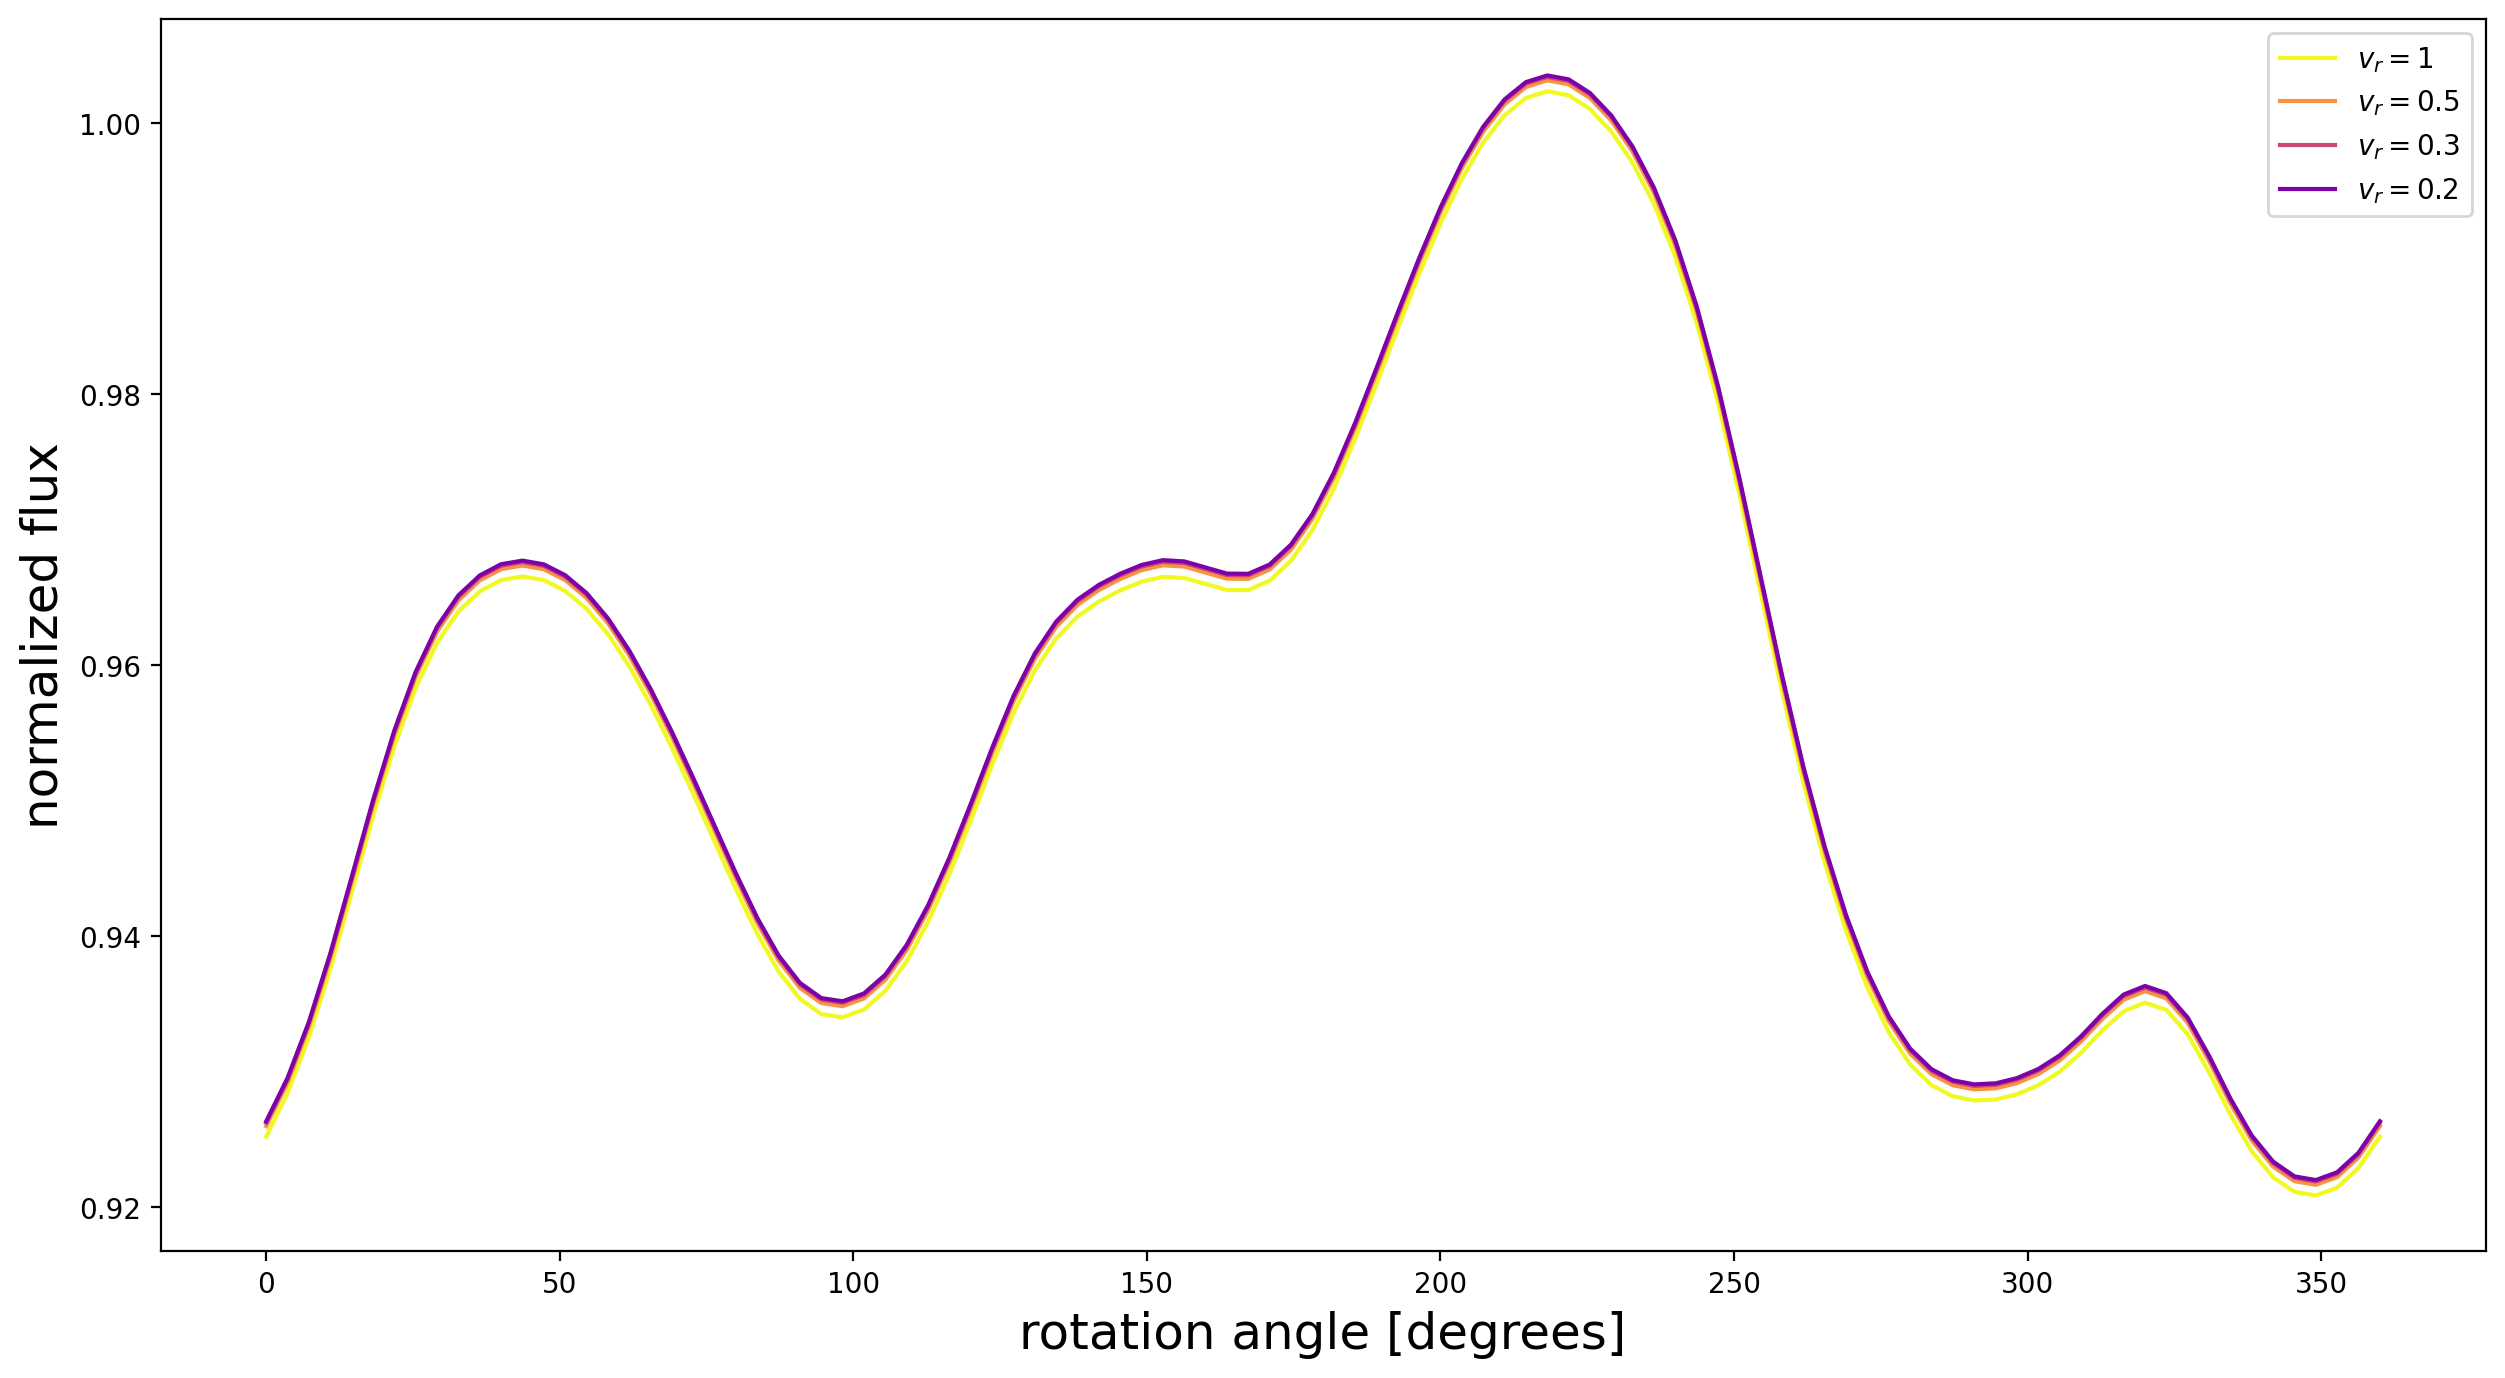

In [19]:
fig, ax = plt.subplots(1, figsize=(15, 8))
cmap = plt.get_cmap("plasma_r")
for n, vrot in enumerate([1, 0.5, 0.3, 0.2]):
    plt.plot(theta, flux(lmax=30, rs=30, theta=theta, y=map.y, inc=90, vrot=vrot), label=f"$v_r={vrot}$", color=cmap(n/4))
plt.xlabel("rotation angle [degrees]", fontsize=18)
plt.ylabel("normalized flux", fontsize=18)
plt.legend()

In [98]:
def intensity_at_point(r, lon, lat, lmax, rs, vrot):
    theta = np.pi / 2 - np.deg2rad(lat)
    phi = lon
    
    total_intensity = 0
    for l in range(lmax + 1):
        total_intensity += spherical_harmonic_intensity(r, l, rs, vrot)
    
    return total_intensity

intensity = intensity_at_point(30, 30, 45, 30, 2, 0.3)
print(intensity)

38.52396935562282


In [22]:
nx=100
rs=2
x, y = np.linspace(0, np.cos(theta), nx), np.linspace(0, np.sin(theta), nx)
energy(r=np.sqrt(x ** 2 + y ** 2), theta=theta, rs=rs, vrot=1).shape

(100, 100)

In [24]:
lat, lon = transform(x, y, rs=rs)

In [26]:
lon

array([[          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [   0.8681351 ,   -0.76403933,    0.47669479, ...,    0.56055409,
          -0.17854673,   -0.24629952],
       [   1.73637355,   -1.52824873,    0.95359929, ...,    1.12132506,
          -0.35719328,   -0.49273242],
       ...,
       [ 125.24594292, -128.76136667,  142.15148286, ...,  137.58081613,
        -163.77318404, -158.1258262 ],
       [ 131.52392709, -135.17499906,  148.19728657, ...,  143.90107768,
        -166.92476484, -162.23533377],
       [ 147.29577951, -150.52958878,  160.57961507, ...,  157.48207411,
        -172.47775032, -169.67642096]])

In [27]:
rs = 2
nx = 100

# x, y = np.linspace(-1, 1, nx), np.linspace(-1, 1, nx)
x, y = np.linspace(0, np.cos(theta), nx), np.linspace(0, np.sin(theta), nx)
x, y = np.meshgrid(x, y)
x = x.flatten()
y = y.flatten()
r = np.sqrt(x ** 2 + y ** 2)
lat, lon = transform(x, y, rs=rs)
I = np.zeros((len(theta), nx, nx))
for n in range(len(theta)):
    I[n] = map.intensity(lat=lat, lon=lon - theta[n]).reshape(nx, nx) * energy(r=r, theta=theta[n], rs=rs, vrot=1)
    # I[n] = map.intensity(lat=lat, lon=lon - theta[n]).reshape(nx, nx) * ylm_integrals(lmax=30, rs=rs, vrot=0.3)

: 

: 

In [77]:
map.show(theta=theta, image=I)